# Решение задач c использованием SQL

Для решения задач используется учебная БД, описание данных приведено далее

## Описание данных

Схема исследуемых данных:

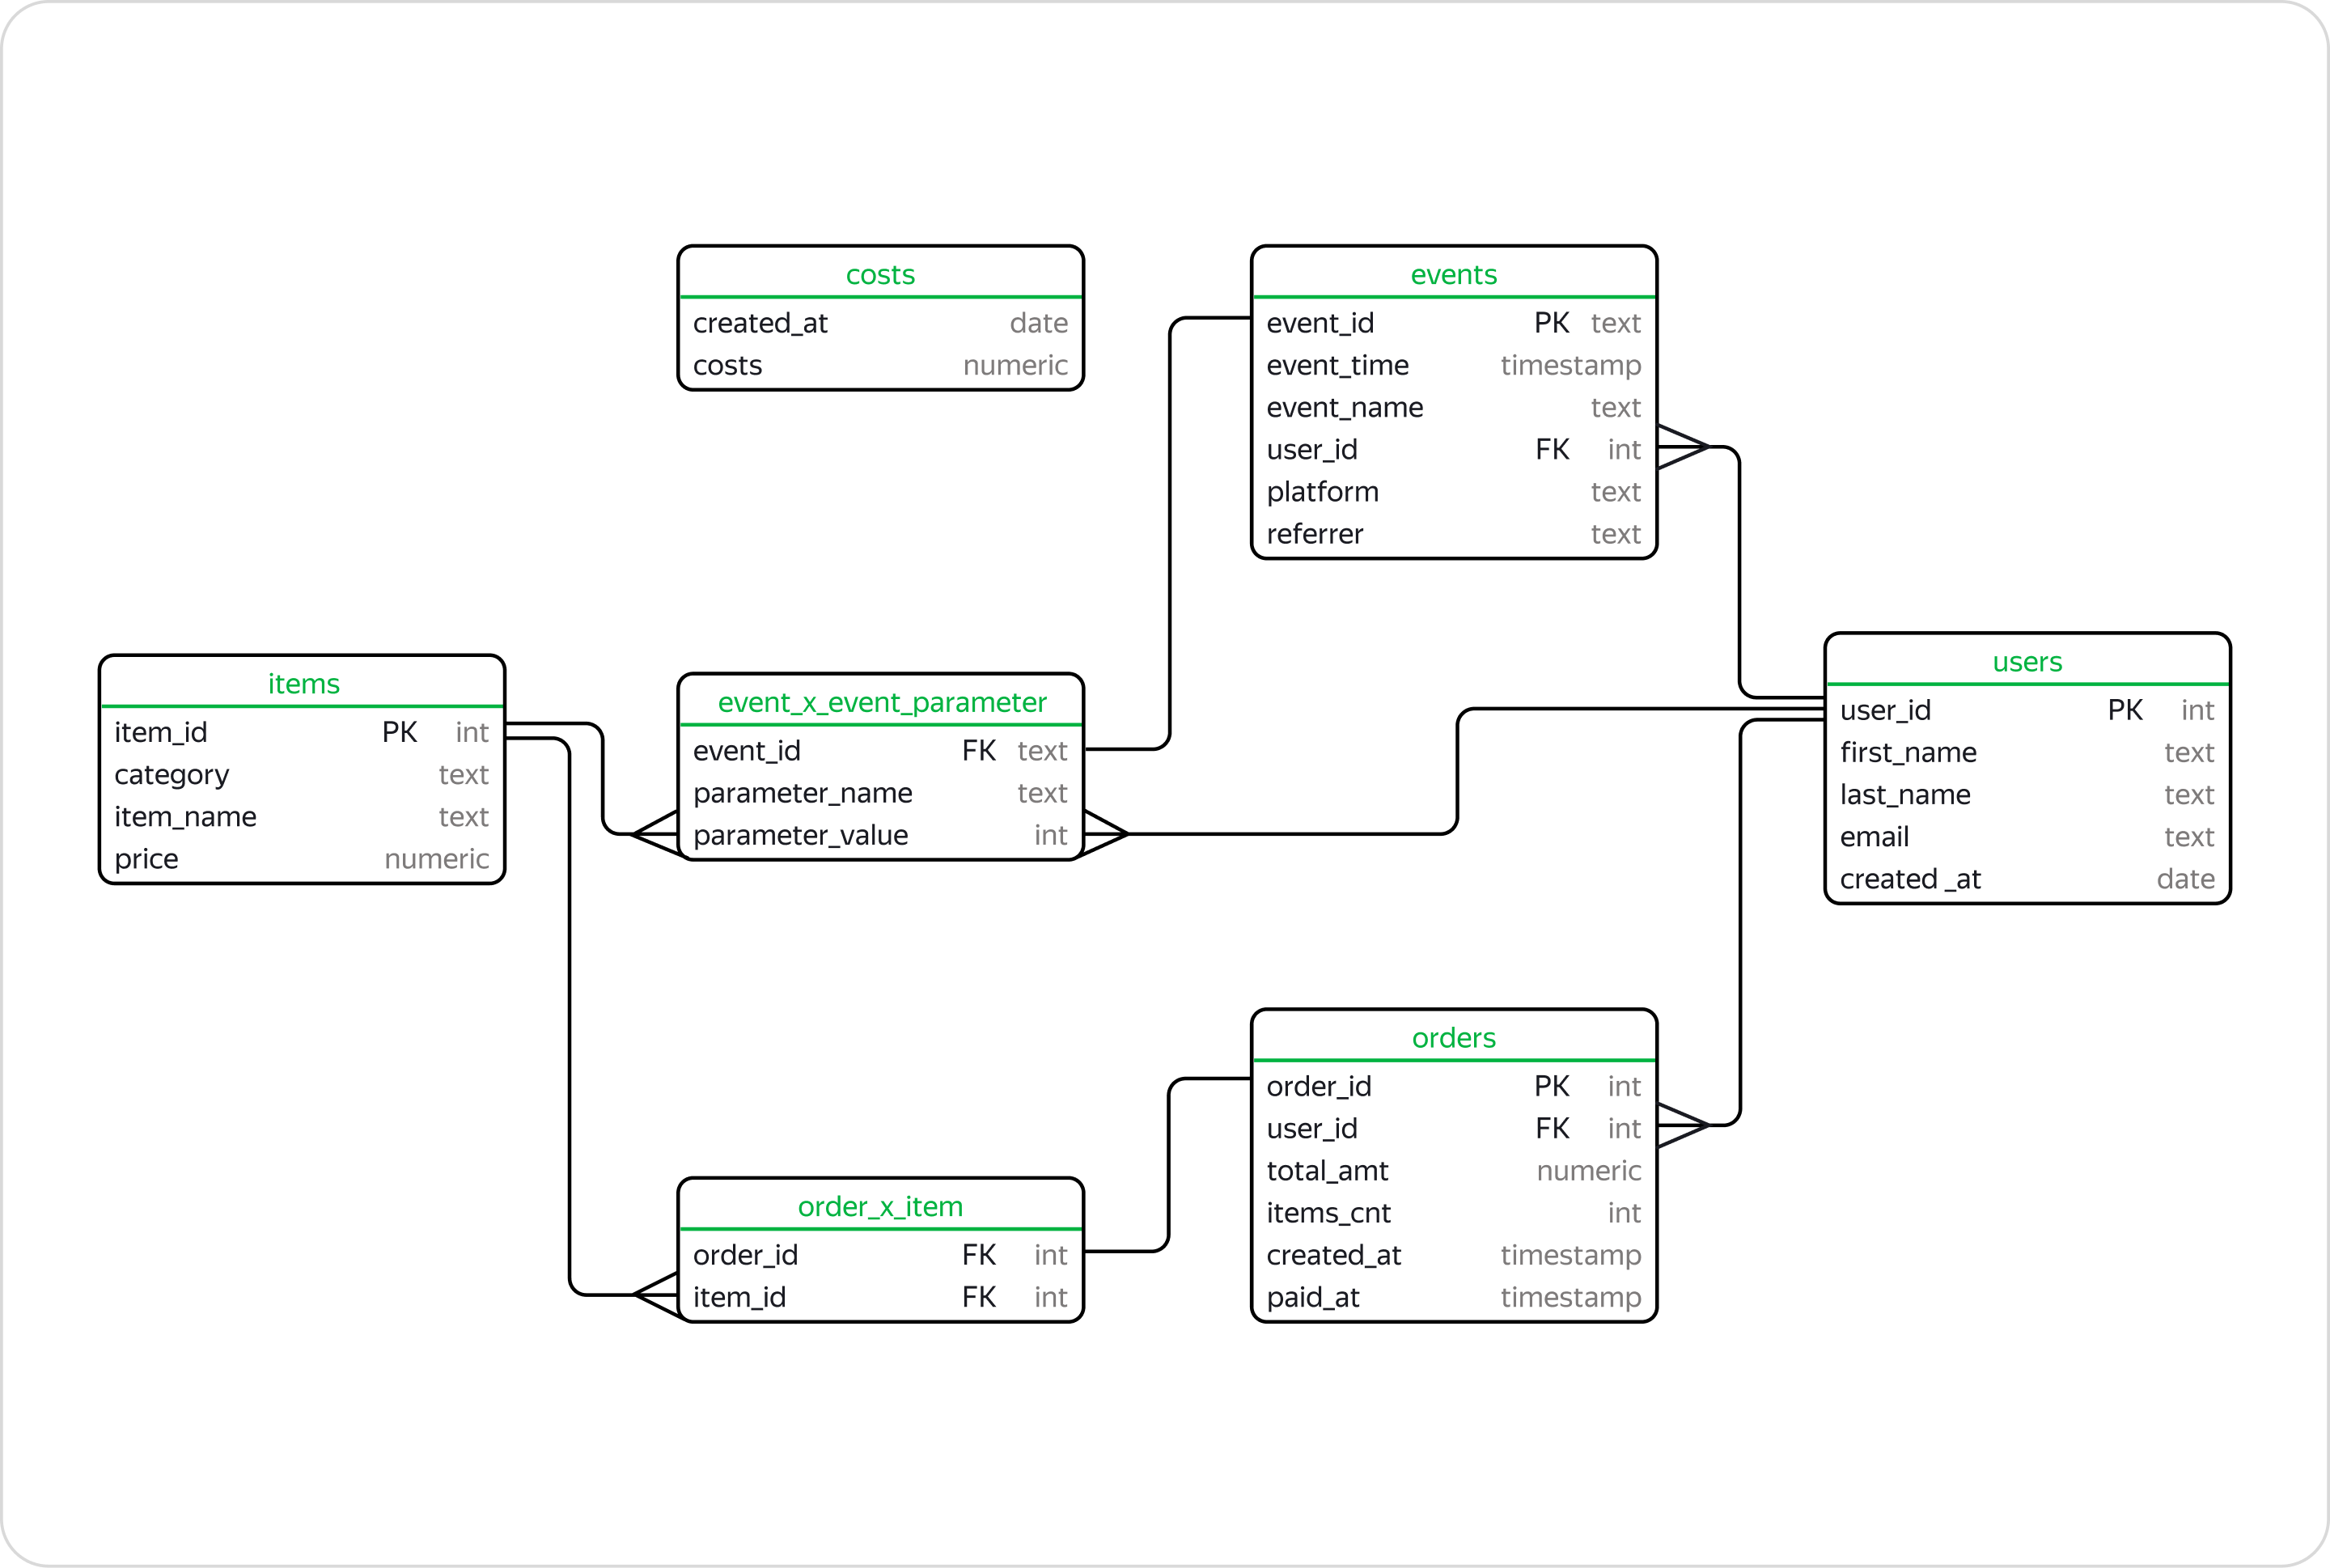

# Таблица users
Cодержит данные о пользователях.

Поля и их описание:
- user_id	Идентификатор пользователя, первичный ключ таблицы
- first_name	Имя пользователя
- last_name	Фамилия пользователя
- email	Электронный адрес пользователя
- created_at	Дата создания аккаунта пользователя
# Таблица events
Содержит данные о событиях.
Поля и их описание:
- event_id	Идентификатор события, первичный ключ таблицы
- event_time	Дата и время события
- event_name	Название события
- user_id	Идентификатор пользователя, внешний ключ, отсылающий к таблице users
- platform	Тип устройства пользователя
- referrer	Источник события пользователя
- Типов событий в поле event_name два:
- view_item — просмотр товара;
- view_user_profile — просмотр сохранённых товаров другого пользователя.

Значение в поле referrer показывает, какой источник просматривал пользователь перед тем, как совершилось событие. Источники могут быть внешними:

- google_search — поисковая система Google;
- promo_email_click — рассылка магазина.

В поле referrer могут быть указаны и источники внутри сайта:
- item_page — страница товара;
- user_wishlist — страница сохранённых товаров другого пользователя;
- shopping_cart — корзина;
- home — главная страница магазина.
# Таблица event_x_parameter
Содержит детальную информацию о событиях.
Поля и их описание:
- event_id	Идентификатор события, внешний ключ, отсылающий к таблице events
- parameter_name	Параметр детализации
- parameter_value	Значение параметра

Если в поле parameter_name указан item_id, то в parameter_value будет храниться идентификатор товара, который просматривал пользователь.

Если в поле parameter_name указан viewed_user_id, то в parameter_value будет храниться идентификатор пользователя, чью страницу с сохранёнными товарами смотрел другой пользователь.
# Таблица orders
Содержит детальные данные о заказах пользователей.
Поля и их описание:
- order_id	Идентификатор заказа, первичный ключ таблицы
- user_id	Идентификатор пользователя, оформившего заказ
- total_amt	Общая сумма заказа
- items_cnt	Количество товаров в заказе
- created_at	Дата, когда пользователь оформил заказ, но ещё не оплатил его
- paid_at	Дата оплаты заказа
# Таблица items
Содержит данные о товарах.
Поля и их описание:
- item_id	Идентификатор товара, первичный ключ таблицы
- category	Категория товара
- item_name	Название товара
- price	Стоимость
# Таблица order_x_item
Содержит данные о связи заказа с товарами.
Поля и их описание:
- order_id	Идентификатор заказа, внешний ключ, отсылающий к таблице orders
- item_id	Идентификатор товара, внешний ключ, отсылающий к таблице items
# Таблица costs
Содержит данные о стоимости привлечения пользователей.
Поля и их описание:
- created_at	Дата
- costs	Стоимость привлечения

## Решение задач

Для начала загрузим необходимые библиотеки и выполним  подключение к БД

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 
import seaborn as sns

In [3]:
db_config = {
    'user': user, # имя пользователя и пароль были удалены из блокнота
    'pwd': passw, # пароль
    'host': 'localhost',
    'port': 5432, # порт подключения
    'db': 'new_database' # название базы данных
} 

In [4]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
) 

In [5]:
engine = create_engine(connection_string) 


### Задача 1
Рассчитаем LTV для каждого месяца, в итоговую таблицу должны войти два поля: месяц создания аккаунта и значение LTV 

In [6]:
query1 = '''
SELECT CAST(DATE_TRUNC('month',u.created_at) AS date) AS month,
    ROUND(SUM(o.total_amt) / COUNT(DISTINCT(o.user_id)), 2) AS LTV
FROM tools_shop.orders AS o
    JOIN tools_shop.users AS u ON u.user_id = o.user_id
GROUP BY month
''' 

ltv = pd.read_sql_query(query1, con = engine) 
ltv.head()

,month,ltv
0,2016-02-01,9.42
1,2016-03-01,251.38
2,2016-04-01,265.82
3,2016-05-01,231.30
4,2016-06-01,231.67


### Задача 2
Необходимо рассчитать ARPPU в разрезе года оформления заказа с точностью до двух знаков после запятой.

In [7]:
query2 = '''
SELECT CAST(DATE_TRUNC('YEAR', o.created_at) AS date), 
       ROUND(SUM(o.total_amt) / COUNT(DISTINCT u.user_id), 2) AS arppu
FROM tools_shop.orders o
JOIN tools_shop.users u ON o.user_id = u.user_id
GROUP BY CAST(DATE_TRUNC('YEAR', o.created_at) AS date);
''' 

arppu = pd.read_sql_query(query2, con = engine) 
arppu.head()

,date_trunc,arppu
0,2016-01-01,264.61
1,2017-01-01,266.38
2,2018-01-01,270.71
3,2019-01-01,265.21
4,2020-01-01,282.91


### Задача 3
Необходимо рассчитать ROI в динамике по месяцам

In [8]:
query3 = '''
SELECT -- добавляем нужные поля и расчёты
    cos.dt ,
    ROUND(ord.total_amt * 100 / cos.costs, 2) AS ROI

FROM
(SELECT DATE_TRUNC('month', created_at)::date AS dt,
       SUM(costs) AS costs
FROM tools_shop.costs
GROUP BY dt) as cos
--  соединяем подзапросы
    JOIN
    (SELECT DATE_TRUNC('month', paid_at)::date AS dt,
           SUM(total_amt) AS total_amt
    FROM tools_shop.orders
    GROUP BY dt) as ord ON ord.dt = cos.dt
ORDER BY  dt;
''' 

roi = pd.read_sql_query(query3, con = engine) 
roi.head(10)

,dt,roi
0,2016-03-01,383.18
1,2016-04-01,278.02
2,2016-05-01,356.64
3,2016-06-01,327.14
4,2016-07-01,317.74
5,2016-08-01,326.79
6,2016-09-01,336.54
7,2016-10-01,322.19
8,2016-11-01,303.23
9,2016-12-01,328.06


### Задача 4
Проранжируем записи в таблице tools_shop.orders по дате оплаты заказа — от большей к меньшей, выведем стоимость заказа с рангом 50.

In [9]:
query4 = '''
WITH orders AS 
    (SELECT *, 
     ROW_NUMBER() OVER (ORDER BY paid_at DESC) AS rn
     FROM tools_shop.orders)
     
SELECT total_amt
FROM orders
WHERE rn = 50
''' 

rang_50 = pd.read_sql_query(query4, con = engine) 
rang_50.head()

,total_amt
0,1431.0


### Задача 5
Напишим запрос к таблице orders, который выведет:
- месяц заказа, приведённый к типу date;
- сумму заказа total_amt;
- сумму заказа с накоплением, отсортированную по возрастанию месяца оформления заказа.

In [10]:
query5 = '''
SELECT CAST(DATE_TRUNC('month', created_at) AS date) AS month,
        total_amt,
        SUM(total_amt) OVER (ORDER BY DATE_TRUNC('month', created_at)) AS accum_sum
FROM tools_shop.orders
ORDER BY month;
''' 

accumulated_sum = pd.read_sql_query(query5, con = engine) 
accumulated_sum.head()

,month,total_amt,accum_sum
0,2016-03-01,387.50,500.40
1,2016-03-01,64.50,500.40
2,2016-03-01,48.40,500.40
3,2016-04-01,209.00,1069.37
4,2016-04-01,13.32,1069.37


### Задача 6 
Составим запрос, который выведет сумму выручки по годам и разницу выручки между текущим и следующим годом. Разница должна показывать, на сколько выручка следующего года отличается от текущего. В случае, если данных по следующему году нет, укажем ноль.

Выгрузим поля:
- год, приведённый к типу date;
- выручка за текущий год;
- разница в выручке между текущим и следующим годом.

In [11]:
query6 = '''
WITH revl AS
(SELECT DATE_TRUNC('year', paid_at )::date AS year,
    SUM(total_amt) AS rev
FROM tools_shop.orders
GROUP BY year)

SELECT year, 
        rev,
        ---LEAD(revenue) OVER (ORDER BY year) AS diff,
        LEAD(rev,1,rev) OVER (ORDER BY year) - rev AS diff_with_next_year
FROM revl
''' 

diff_revenue = pd.read_sql_query(query6, con = engine) 
diff_revenue.head()

,year,rev,diff_with_next_year
0,2016-01-01,136017.66,429736.05
1,2017-01-01,565753.71,336605.77
2,2018-01-01,902359.48,258161.33
3,2019-01-01,1160520.81,262563.06
4,2020-01-01,1423083.87,-784363.73


### Задача 7
Рассчитаем Retention Rate по месяцам, возвращение определяем по любому действию из таблицы events, которое совершил пользователь.

In [12]:
query7 = '''
WITH profile AS
  (SELECT u.user_id,
          DATE_TRUNC('month', MIN(event_time))::date AS dt
   FROM tools_shop.users u
   JOIN tools_shop.orders o ON u.user_id = o.user_id
   JOIN tools_shop.events e ON u.user_id = e.user_id
   GROUP BY 1), 
   
sessions AS
  (SELECT p.user_id,
          DATE_TRUNC('month', event_time)::date AS session_dt
   FROM tools_shop.events e
   JOIN profile p ON p.user_id = e.user_id
   GROUP BY 1,
            2),
            
cohort_users_cnt AS
  (SELECT dt,
          COUNT(user_id) AS cohort_users_cnt
   FROM profile
   GROUP BY 1)
   
SELECT  cuc.dt cohort_month,
        s.session_dt session_month,
        COUNT(p.user_id) ,
        cohort_users_cnt,
        ---ROUND(COUNT(p.user_id) * 100.0 / cohort_users_cnt, 2) AS retention_rate
        ROUND(COUNT(p.user_id) * 100.0/cohort_users_cnt, 2) AS retention_rate
FROM cohort_users_cnt AS cuc JOIN profile AS p ON p.dt=cuc.dt JOIN sessions AS s ON s.user_id=p.user_id
GROUP BY 1,2,4
ORDER BY cohort_month
''' 

retention_rate_df = pd.read_sql_query(query7, con = engine) 
retention_rate_df.head()

,cohort_month,session_month,count,cohort_users_cnt,retention_rate
0,2016-03-01,2016-03-01,4,4,100.00
1,2016-03-01,2016-08-01,1,4,25.00
2,2016-03-01,2016-09-01,2,4,50.00
3,2016-03-01,2016-07-01,2,4,50.00
4,2016-04-01,2020-12-01,1,12,8.33
